### This notebook evaluates precipitation efficiency for MCSs in the idealized RCE simulations.

In [15]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings, random
from matplotlib import cm
import scipy.optimize
from random import randint
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

# blue-to-red colormap
BR_color_cycle = ["navy", "blue", "lightskyblue", "tomato", "red", "darkred"]

In [2]:
# parameters needed in this script
eps = 0.01802/0.02897 # ratio of MW_water to MW_air
g = 9.8 # gravity [m s-2]
rho_w = 997 # density of water [kg m-3]
R_air = 287.058 # [J kg-1 K-1]

### Loading RCE data and precipitation efficiency calculation

In [3]:
path = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/all-var-percentile/'
ssts = np.arange( 290, 315, 5 )
mean_RCE, p99_RCE, rad = read_RCE_files( path )
rad_RCE = np.concatenate( [r for r in rad], axis=0 )
altitudes = mean_RCE[0]['z']

In [4]:
path_core = '/groups/sylvia/JAS-MCS-rain/RCE-postprocessed/execution2/'
mean_RCE_core, p99_RCE_core, rad_core = read_RCE_files( path_core )
rad_RCE_core = np.concatenate( [r for r in rad_core], axis=0 )

In [5]:
peff_list = [ [] for i in np.arange( len(mean_RCE) ) ]
rad_RCE_sub = [ [] for i in np.arange( len(mean_RCE) ) ]

# Calculate the gradient with respect to pressure of the saturation vapor mixing ratio
for iterator, array in enumerate( mean_RCE ):
    precip_RCE = array['p_rate']
    T_RCE = array['TABS']
    p_RCE = array['p'] * 100. # converting hPa -> Pa
    z_RCE = array['z']
    qvsat_RCE = eps * satVapP_liq(T_RCE) / ( p_RCE - satVapP_liq(T_RCE) )
    RH = array['QV'] / (qvsat_RCE * 1000.) # factor of 1000. to put both in [g kg-1]

    # Then calculate the gradient versus altitude in that saturation vapor mixing ratio
    dqvsat_dz_RCE = qvsat_RCE.differentiate( 'z' )
    
    # Determine the lifting condensation level, Tdew from the Magnus formula
    Tsfc_mean = T_RCE[:,0].mean( dim={'clusters'} )
    RHsfc_mean = RH[:,0].mean( dim={'clusters'} )
    Tdew_mean = dew_point_temperature( Tsfc_mean, RHsfc_mean )
    LCL = (Tsfc_mean - Tdew_mean).values/8*1000.
    k = np.abs( LCL - z_RCE ).argmin( 'z' ).values

    # Determine the cold-point tropopause,
    # i.e. where the temperature change becomes negative as the stratosphere warms
    Tmean = T_RCE.mean( dim={'clusters'} )
    j = np.argwhere( (Tmean[:-1].values - Tmean[1:].values) < 0 )[0,0]
    
    # Convert pressure velocity to vertical velocity
    rho_air = p_RCE / (R_air * T_RCE) # [kg m-3]
    w_RCE = -1.*array['omega'] / rho_air / g # [m s-1]
    w_RCE = xr.where( w_RCE>0, w_RCE, 0. )
    
    # Multiply the gradient with respect to altitude by vertical velocity
    #integrand = w_RCE[ii] * dqvsat_dz_RCE[ii] * rho_air
    integrand = w_RCE * dqvsat_dz_RCE * rho_air
    
    # Integrate the condensation rate over the altitudes
    cond_rate_RCE = integrand[:,k+1:j-1].integrate( coord='z' )  #[:,k+1:j-1]
    peff_RCE = -1.*precip_RCE / 3600 / cond_rate_RCE  # index 0 for p_RCE is the surface
    zscore = ( peff_RCE - np.nanmean(peff_RCE) )/np.nanstd(peff_RCE)
    peff_list[iterator] = peff_RCE[zscore <= 2]
    rad_RCE_sub[iterator] = [ r for r, z in zip(rad[iterator], zscore) if z <= 2]
    print( np.nanstd(peff_RCE), np.nanmin(peff_RCE), np.nanmedian(peff_RCE), np.nanmean(peff_RCE), np.nanpercentile(peff_RCE,90) )
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

0.3752573932866285 0.0 0.7012216873641439 0.6500816913915116 1.0791099635597
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.3887963863335865 0.0 0.6229163348106798 0.5558507335152524 0.9922922527387258
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.37524174373762353 0.0 0.5151469552061461 0.4564352670257868 0.887113349842904
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.34317528199623143 0.0 0.35988882025738106 0.35338875042936074 0.7460753911631597
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.32423107496937215 0.0 0.3359415410379488 0.32673744732475635 0.6792363528121601
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [6]:
# Filter for size
loo = np.percentile( rad_RCE, 25 )
upp = np.percentile( rad_RCE, 75 )
all_precipeff = np.concatenate( [p for p in peff_list] )
rad_RCE_subarray = np.concatenate( [ r for r in rad_RCE_sub ] )
precip_eff_small = all_precipeff[ rad_RCE_subarray <= loo ]
precip_eff_large = all_precipeff[ rad_RCE_subarray >= upp ]
print( np.nanmin(all_precipeff), np.nanmedian(all_precipeff), np.nanmean(all_precipeff), np.nanpercentile(all_precipeff,90) )
print( np.nanmin(precip_eff_small), np.nanmedian(precip_eff_small), np.nanmean(precip_eff_small), np.nanpercentile(precip_eff_small,90) )
print( np.nanmin(precip_eff_large), np.nanmedian(precip_eff_large), np.nanmean(precip_eff_large), np.nanpercentile(precip_eff_large,90) )

0.0 0.43970883476668815 0.42357705903249326 0.8834520708845929
0.0 0.4006574525645765 0.4125208782364646 0.896001105340932
0.0 0.42812727885158075 0.4016901604267583 0.7951327911370363


### Load in condensate amounts and calculate CWP

In [7]:
# across various SSTs
cwp_list = [ [] for i in np.arange( len(mean_RCE) ) ]
qc_list = [ [] for i in np.arange( len(mean_RCE) ) ]
for iterator, array in enumerate( mean_RCE ):
    T_RCE = array['TABS']
    p_RCE = array['p'] * 100. # converting hPa -> Pa
    altitudes = array['z']
    rho_air = p_RCE / (R_air * T_RCE) # [kg m-3]
    condensate_RCE = array['QN'] / 1000 # [kg kg-1] (from [g kg-1])
    cwp_list[iterator] = np.trapz( condensate_RCE * rho_air, altitudes ) # [kg m-2]
    qc_list[iterator] = np.nanmedian( array['QN'], axis=0 )

In [8]:
# across various SSTs -- for precipitating cells only
cwp_list_core = [ [] for i in np.arange( len(mean_RCE_core) ) ]
qc_list_core = [ [] for i in np.arange( len(mean_RCE_core) ) ]
for iterator, array in enumerate( mean_RCE_core ):
    T_RCE = array['TABS']
    p_RCE = array['p'] * 100. # converting hPa -> Pa
    altitudes = array['z']
    rho_air = p_RCE / (R_air * T_RCE) # [kg m-3]
    condensate_RCE_core = array['QN'] / 1000 # [kg kg-1] (from [g kg-1])
    cwp_list_core[iterator] = np.trapz( condensate_RCE_core * rho_air, altitudes ) # [kg m-2]
    qc_list_core[iterator] = np.nanmedian( array['QN'], axis=0 )

In [9]:
# across all SSTs and stratifying for extent
condensate_RCE = RCE_concat( mean_RCE, 'QN' )/1000 # [kg kg-1] (from [g kg-1])
T_RCE_all = RCE_concat( mean_RCE, 'TABS' )
p_RCE_all = RCE_concat( mean_RCE, 'p' )*100 # [Pa] (from [hPa])
rho_air = p_RCE_all / (R_air * T_RCE_all) # [kg m-3]

CWP_RCE = np.zeros( (condensate_RCE.shape[0],) )
for i in np.arange(condensate_RCE.shape[0]):
    j = np.argwhere( ~np.isnan(condensate_RCE[i]) )
    start = j[0][0]
    end = j[-1][0]
    CWP_RCE[i] = np.trapz( condensate_RCE[i,start:end] * rho_air[i,start:end], altitudes[start:end] ) # [kg m-2]

CWP_small = CWP_RCE[ rad_RCE <= loo ]
CWP_large = CWP_RCE[ rad_RCE >= upp ]

condensate_RCE_med = np.nanmean( condensate_RCE, axis=0 )*1000. # convert back to [g kg-1] here
condensate_RCE_p99 = np.nanpercentile( condensate_RCE, 90, axis=0 )*1000.
condensate_large = np.nanmean( condensate_RCE[rad_RCE >= upp], axis=0 )*1000. # convert back to [g kg-1] here
condensate_large_p99 = np.nanpercentile( condensate_RCE[rad_RCE >= upp], 90, axis=0 )*1000.
condensate_small = np.nanmean( condensate_RCE[rad_RCE <= loo], axis=0 )*1000. # convert back to [g kg-1] here
condensate_small_p99 = np.nanpercentile( condensate_RCE[rad_RCE <= loo], 90, axis=0 )*1000.

In [10]:
# across all SSTs and stratifying for extent -- for precipitating cells only
condensate_RCE_core = RCE_concat( mean_RCE_core, 'QN' )/1000 # [kg kg-1] (from [g kg-1])
T_RCE_all = RCE_concat( mean_RCE_core, 'TABS' )
p_RCE_all = RCE_concat( mean_RCE_core, 'p' )*100 # [Pa] (from [hPa])
rho_air = p_RCE_all / (R_air * T_RCE_all) # [kg m-3]

CWP_RCE_core = np.zeros( (condensate_RCE_core.shape[0],) )
for i in np.arange(condensate_RCE_core.shape[0]):
    j = np.argwhere( ~np.isnan(condensate_RCE_core[i]) )
    if len(j) != 0:
        start = j[0][0]
        end = j[0][-1]
        CWP_RCE_core[i] = np.trapz( condensate_RCE_core[i] * rho_air[i], altitudes ) # [kg m-2]
    else:
        CWP_RCE_core[i] = np.nan

CWP_core_small = CWP_RCE_core[ rad_RCE_core <= loo ]
CWP_core_large = CWP_RCE_core[ rad_RCE_core >= upp ]

condensate_RCE_core_med = np.nanmean( condensate_RCE_core, axis=0 )*1000. # convert back to [g kg-1] here
condensate_RCE_core_p99 = np.nanpercentile( condensate_RCE_core, 90, axis=0 )*1000.
condensate_core_large = np.nanmean( condensate_RCE_core[rad_RCE_core >= upp], axis=0 )*1000. # convert back to [g kg-1] here
condensate_core_large_p99 = np.nanpercentile( condensate_RCE_core[rad_RCE_core >= upp], 90, axis=0 )*1000.
condensate_core_small = np.nanmean( condensate_RCE_core[rad_RCE_core <= loo], axis=0 )*1000. # convert back to [g kg-1] here
condensate_core_small_p99 = np.nanpercentile( condensate_RCE_core[rad_RCE_core <= loo], 90, axis=0 )*1000.

In [11]:
print( (np.nanmedian(CWP_large) - np.nanmedian(CWP_small))/np.nanmedian(CWP_small) )
print( condensate_small_p99/condensate_large_p99 )
print( altitudes )

-0.03717906656330417
[0.98780796 1.04373104 0.9341464  0.91380583 0.8545609  0.89000137
 0.98368944 1.0745442  1.18072845 1.25323939 1.23508059 1.23410843
 1.23747064 1.22551208 1.22999343 1.29895481 1.20421299 1.20721126
 1.26362096 1.27313441 1.28294937 1.33354814 1.40716283 1.36747243
 1.32719198 1.37660092 1.42827839 1.38106383 1.33535166 1.3156681
 1.32979203 1.35142673 1.3844103  1.37404193 1.38995739 1.40123033
 1.3247463  1.21351429 1.02190227 0.86624647 0.62392455 0.53692095
 0.29888556 0.32315236 0.52188171 0.4727327  0.70697261 0.76932849
 0.28752294 0.                nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
<xarray.DataArray 'z' (z: 64)>
array([   37.,   112.,   194.,   288.,   395.,   520.,   667.,   843.,  1062.,
        1331.,  1664.,  2055.,  2493.,  2966.,  3459.,  3959.,  4459.,  4959.,
        5459.,  5959.,  6459.,  6959.,  7459.,  7959.,  8459.,  8959.,  945

### Plot the cloud water path PDFs and condensate profiles

In [20]:
# Evaluate statistical significance of PDF shifts
for i in np.arange( 1, 5 ):
    h1, _ = np.histogram( cwp_list[0], bins=np.linspace(lower2, upper2, nbin2) )
    h2, _ = np.histogram( cwp_list[i], bins=np.linspace(lower2, upper2, nbin2) )
    statistic, p_value = ks_2samp( h1, h2 )
    print( statistic, p_value )

h1, _ = np.histogram( CWP_core_small, bins=np.linspace(lower2, upper3, nbin2) )
h2, _ = np.histogram( CWP_core_large, bins=np.linspace(lower2, upper3, nbin2) )
statistic, p_value = ks_2samp( h1, h2 )

0.15789473684210525 0.978077940445305
0.3157894736842105 0.3056890512159651
0.42105263157894735 0.06808911421959735
0.47368421052631576 0.026749480251438945


[7.49449725e-04 2.26202610e-03 4.75196703e-03 7.96879340e-03
 1.17641785e-02 2.04217340e-02 3.82285725e-02 7.10360036e-02
 1.30916669e-01 1.87215788e-01 1.99179602e-01 2.10080470e-01
 2.22367686e-01 2.39591434e-01 2.86793918e-01 3.64459265e-01
 3.96306918e-01 4.42724966e-01 5.40250039e-01 5.78825537e-01
 5.91701770e-01 7.00029021e-01 7.38061557e-01 7.68849161e-01
 8.05692573e-01 8.81109911e-01 9.36326920e-01 9.67960572e-01
 9.66603402e-01 9.86574916e-01 1.00094220e+00 1.02790352e+00
 1.00175710e+00 9.72331036e-01 8.89055838e-01 7.59813702e-01
 6.09854062e-01 4.25924780e-01 2.69692304e-01 1.67458798e-01
 8.09277190e-02 2.91407214e-02 7.96860058e-03 2.55821124e-03
 1.04389551e-03 3.72373023e-04 3.49462482e-04 2.66940077e-04
 2.66186255e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


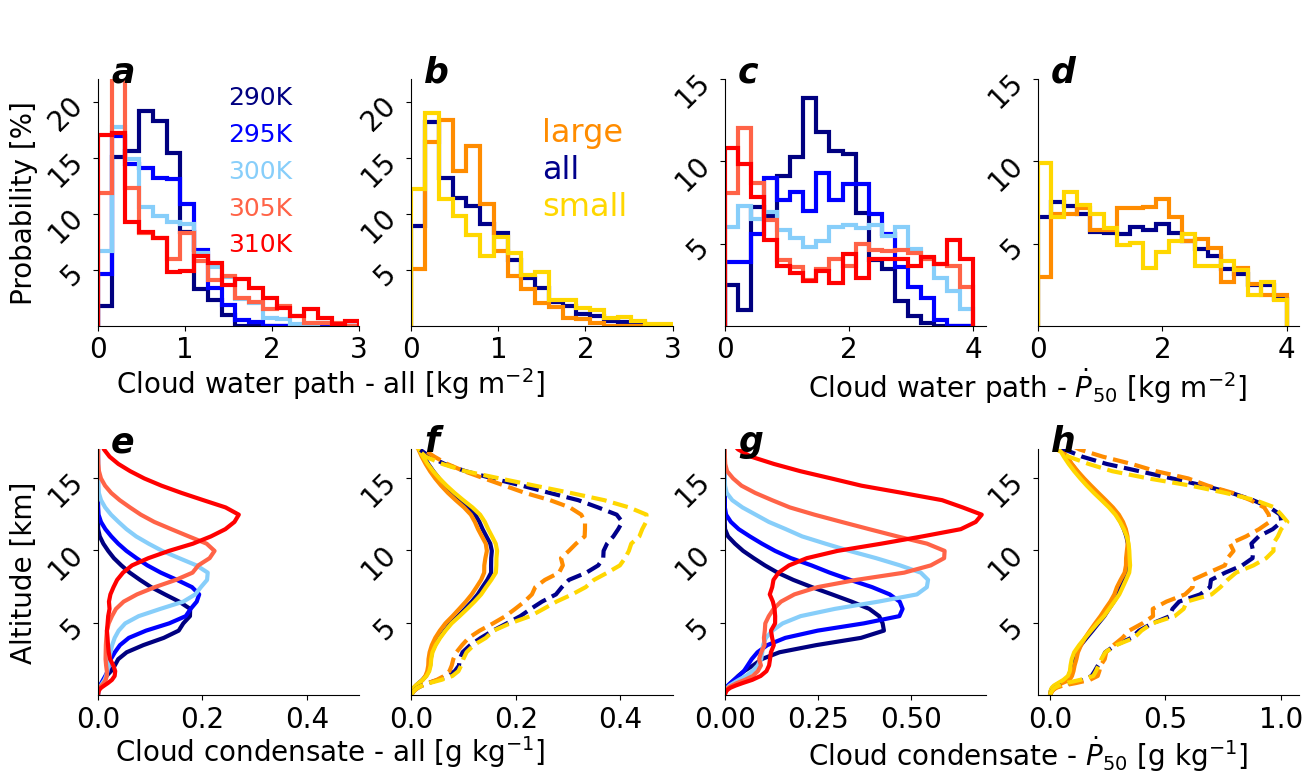

In [12]:
lower2 = 0
upper2 = 3
upper3 = 4
nbin = 35
nbin2 = 20
fs = 20
xlab = [ r'Cloud water path - all [kg m$^{-2}$]', r'Cloud water path - $\dot{P}_{50}$ [kg m$^{-2}$]',
         r'Cloud condensate - all [g kg$^{-1}$]', r'Cloud condensate - $\dot{P}_{50}$ [g kg$^{-1}$]' ]
fig, ax = plt.subplots( 2, 4, figsize =(15.5, 8), constrained_layout=True )
fig.subplots_adjust(hspace=0.5) 

for j, i, k, m, l in zip( cwp_list, cwp_list_core, qc_list, qc_list_core, np.arange(len(peff_list)) ):
    wgts = np.ones_like( j )/float( len( j ) )*100.
    ax[0,0].hist( j, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3,
               edgecolor=BR_color_cycle[l], label=str(ssts[l])+' K' )
    ax[0,0].text( 0.5, 0.9-l*0.15, str(ssts[l]) + 'K', color=BR_color_cycle[l], fontsize=fs-2, transform=ax[0,0].transAxes )
    wgts = np.ones_like( i )/float( len( i ) )*100.
    ax[0,2].hist( i, bins=np.linspace(lower2, upper3, nbin2), histtype='step', weights=wgts, linewidth=3,
               edgecolor=BR_color_cycle[l] )
    
    ax[1,0].plot( k, altitudes/1000., linewidth=3, color=BR_color_cycle[l] )
    ax[1,2].plot( m, altitudes/1000., linewidth=3, color=BR_color_cycle[l] )
    
ax[0,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[1,0].set_ylabel( 'Altitude [km]', fontsize=fs )
ax[1,0].set_ylim( [0, 15] )
ax[1,2].set_ylim( [0, 15] )


wgts = np.ones_like( CWP_RCE )/float( len( CWP_RCE ) )*100.
ax[0,1].hist( CWP_RCE, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )
wgts = np.ones_like( CWP_RCE_core )/float( len( CWP_RCE_core ) )*100.
ax[0,3].hist( CWP_RCE_core, bins=np.linspace(lower2, upper3, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )

wgts = np.ones_like( CWP_large )/float( len( CWP_large ) )*100.
ax[0,1].hist( CWP_large, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
#ax[0,1].plot( [np.nanmedian(CWP_large), np.nanmedian(CWP_large)], [1, 5], ls='-', linewidth=3, color='darkorange' )
wgts = np.ones_like( CWP_core_large )/float( len( CWP_core_large ) )*100.
ax[0,3].hist( CWP_core_large, bins=np.linspace(lower2, upper3, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
#ax[0,3].plot( [np.nanmedian(CWP_core_large), np.nanmedian(CWP_core_large)], [1, 5], ls='-', linewidth=3, color='darkorange' )

wgts = np.ones_like( CWP_small )/float( len( CWP_small ) )*100.
ax[0,1].hist( CWP_small, bins=np.linspace(lower2, upper2, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
#ax[0,1].plot( [np.nanmedian(CWP_small), np.nanmedian(CWP_small)], [1, 5], ls='-', linewidth=3, color='gold' )
wgts = np.ones_like( CWP_core_small )/float( len( CWP_core_small ) )*100.
ax[0,3].hist( CWP_core_small, bins=np.linspace(lower2, upper3, nbin2), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
#ax[0,3].plot( [np.nanmedian(CWP_core_small), np.nanmedian(CWP_core_small)], [1, 5], ls='-', linewidth=3, color='gold' )

ax[1,1].plot( condensate_RCE_med, altitudes/1000., linewidth=3, color='darkblue' )
ax[1,1].plot( condensate_large, altitudes/1000., linewidth=3, color='darkorange' )
ax[1,1].plot( condensate_small, altitudes/1000., linewidth=3, color='gold' )
ax[1,1].plot( condensate_RCE_p99, altitudes/1000., linewidth=3, ls='--', color='darkblue' )
ax[1,1].plot( condensate_large_p99, altitudes/1000., linewidth=3, ls='--', color='darkorange' )
ax[1,1].plot( condensate_small_p99, altitudes/1000., linewidth=3, ls='--', color='gold' )

ax[1,3].plot( condensate_RCE_core_med, altitudes/1000., linewidth=3, color='darkblue' )
ax[1,3].plot( condensate_core_large, altitudes/1000., linewidth=3, color='darkorange' )
ax[1,3].plot( condensate_core_small, altitudes/1000., linewidth=3, color='gold' )
ax[1,3].plot( condensate_RCE_core_p99, altitudes/1000., linewidth=3, ls='--', color='darkblue' )
ax[1,3].plot( condensate_core_large_p99, altitudes/1000., linewidth=3, ls='--', color='darkorange' )
ax[1,3].plot( condensate_core_small_p99, altitudes/1000., linewidth=3, ls='--', color='gold' )
print(condensate_core_small_p99)

let = [ 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h' ]
span_ax = fig.add_axes([0.15, 0.56, 0.25, 0.4], frameon=False) 
span_ax.tick_params( labelcolor='none', top=False, bottom=False, left=False, right=False )
span_ax.set_xlabel( xlab[0], fontsize=fs )
span_ax = fig.add_axes([0.6, 0.56, 0.25, 0.4], frameon=False) 
span_ax.tick_params( labelcolor='none', top=False, bottom=False, left=False, right=False )
span_ax.set_xlabel( xlab[1], fontsize=fs )
span_ax = fig.add_axes([0.15, 0.1, 0.25, 0.4], frameon=False) 
span_ax.tick_params( labelcolor='none', top=False, bottom=False, left=False, right=False )
span_ax.set_xlabel( xlab[2], fontsize=fs )
span_ax = fig.add_axes([0.6, 0.1, 0.25, 0.4], frameon=False) 
span_ax.tick_params( labelcolor='none', top=False, bottom=False, left=False, right=False )
span_ax.set_xlabel( xlab[3], fontsize=fs )

# xlim and ylim set
ax[0,0].set_xlim( [lower2, upper2] )
ax[0,0].set_yticks( [5, 10, 15, 20] )
ax[0,0].set_ylim( [0, 22] )

ax[0,1].set_xlim( [lower2, upper2] )
ax[0,1].set_yticks( [5, 10, 15, 20] )
ax[0,1].set_ylim( [0, 22] )
ax[0,1].text( 0.5, 0.75, 'large', color='darkorange', fontsize=fs+3, transform=ax[0,1].transAxes )
ax[0,1].text( 0.5, 0.6, 'all', color='darkblue', fontsize=fs+3, transform=ax[0,1].transAxes )
ax[0,1].text( 0.5, 0.45, 'small', color='gold', fontsize=fs+3, transform=ax[0,1].transAxes )

ax[0,2].set_xlim( [lower2, upper3+0.2] )
ax[0,2].set_yticks( [5, 10, 15] )
ax[0,2].set_ylim( [0, 15] )

ax[0,3].set_xlim( [lower2, upper3+0.2] )
ax[0,3].set_yticks( [5, 10, 15] )
ax[0,3].set_ylim( [0, 15] )

ax[1,0].set_xlim( [0, 0.5] )
ax[1,0].set_yticks( [5, 10, 15] )
ax[1,0].set_ylim( [0, 17] )

ax[1,1].set_xlim( [0, 0.5] )
ax[1,1].set_yticks( [5, 10, 15] )
ax[1,1].set_ylim( [0, 17] )

ax[1,2].set_xlim( [0, 0.7] )
ax[1,2].set_yticks( [5, 10, 15] )
ax[1,2].set_ylim( [0, 17] )

ax[1,3].set_yticks( [5, 10, 15] )
ax[1,3].set_ylim( [0, 17] )

for i, a in enumerate(ax.flatten()):
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.text( 0.05, 0.99, let[i], style='italic', transform=a.transAxes, weight='bold', fontsize=fs+5 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/condensate-RCE.pdf', bbox_inches='tight' )
plt.show()

In [ ]:
print( np.nanmean(CWP_RCE) )
print( np.nanmean(CWP_RCE_core) )
print( np.nanpercentile(CWP_RCE,99) )
print( np.nanpercentile(CWP_RCE_core,99) )
print( '~~~~~~~~~~~~~~~~~~~~~~~~' )
print( np.nanmean(CWP_large) )
print( np.nanmean(CWP_small) )
print( np.nanpercentile(CWP_large,99) )
print( np.nanpercentile(CWP_small,99) )
print( '~~~~~~~~~~~~~~~~~~~~~~' )
print( np.nanmean(CWP_core_large) )
print( np.nanmean(CWP_core_small) )
print( np.nanpercentile(CWP_core_large,99) )
print( np.nanpercentile(CWP_core_small,99) )
print( '~~~~~~~~~~~~~~~~~~~~~~' )
for j, i in zip( cwp_list, cwp_list_core ):
    print( np.nanmedian(i) )

In [ ]:
for j, i in zip( cwp_list, cwp_list_core ):
    wgts = np.ones_like( i )/float( len( i ) )*100.
    h, edges = np.histogram( i, bins=np.linspace(lower2, upper3, nbin2), weights=wgts )
    print( h )
print( edges )

In [ ]:
lower = -1.5
upper = 0.15
xlab = [ r'Precip efficiency $\varepsilon_p$ [-]', r'Precip efficiency $\varepsilon_p$ [-]' ]
fig, ax = plt.subplots( 1, 2, figsize =(9, 4), constrained_layout=True )

for i, l in zip( peff_list, np.arange(len(peff_list)) ):
    wgts = np.ones_like( i )/float( len( i ) )*100.
    ax[0].hist( i, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3,
               edgecolor=BR_color_cycle[l] )
    ax[0].plot( [np.nanmedian(i), np.nanmedian(i)], [15, 20], linewidth=3, ls='-',
               color=BR_color_cycle[l], label=str(ssts[l])+' K' )
    
wgts = np.ones_like( all_precipeff )/float( len( all_precipeff ) )*100.
ax[1].hist( all_precipeff, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3, edgecolor='darkblue' )
ax[1].plot( [np.nanmedian(all_precipeff), np.nanmedian(all_precipeff)], [5, 10], ls='-', linewidth=3, color='darkblue' )

wgts = np.ones_like( precip_eff_small )/float( len( precip_eff_small ) )*100.
ax[1].hist( precip_eff_small, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3, edgecolor='gold' )
ax[1].plot( [np.nanmedian(precip_eff_small), np.nanmedian(precip_eff_small)], [5, 10], ls='-', linewidth=3, color='gold' )

wgts = np.ones_like( precip_eff_large )/float( len( precip_eff_large ) )*100.
ax[1].hist( precip_eff_large, bins=np.logspace(lower, upper, nbin), histtype='step', weights=wgts, linewidth=3, edgecolor='darkorange' )
ax[1].plot( [np.nanmedian(precip_eff_large), np.nanmedian(precip_eff_large)], [5, 10], ls='-', linewidth=3, color='darkorange' )
ax[1].set_ylim( [0, 10] )

let = [ 'a', 'b' ]
for i, a in enumerate(ax):
    a.set_xlabel( r'Precip efficiency $\varepsilon_p$ [-]', fontsize=fs )
    a.set_xscale( 'log' )
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.set_xlim( [10**lower, 10**upper] )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.text( 0.05, 0.92, let[i], style='italic', transform=a.transAxes, weight='bold', fontsize=fs+5 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/precipeff-RCE.pdf', bbox_inches='tight' )
plt.show()